#**Práctica 2: clasificación de dígitos MNIST mediante AdaBoost**

#**1. Introducción**

Importar librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from keras.datasets import mnist

Desde la libería de Keras podemos descargar la base datos MNIST

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
x_train.shape,y_train.shape

((60000, 28, 28), (60000,))

Guardar base de datos en un fichero

In [4]:
np.savez("mnist",x=x_train,y=y_train)

Cargar base de datos desde un fichero

In [5]:
npzfile = np.load("mnist.npz")
mnist_X = npzfile['x']
mnist_Y = npzfile['y']
mnist_X.shape

(60000, 28, 28)

Mostrar una imagen de MNIST

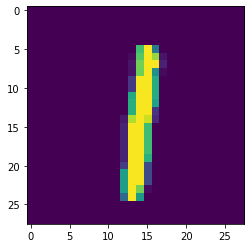

Etiqueta: 1


In [6]:
plt.figure()
plt.imshow(x_train[40])
plt.show()
print("Etiqueta: " + str(y_train[40]))

#**2. Implementación AdaBoost**

##**2.1 Adaptar conjuntos y clase**

Adaptación de los arrays de imágenes y etiquetas para AdaBoost:
Lo que hacemos es cambiar la forma de la matriz X, para que sea un simple vector de 60000x784, utilizando reshape()

In [7]:
def adaptar_conjuntos(X, Y):
    X = mnist_X.reshape(60000,28*28)
    Y = mnist_Y
    return (X,Y)
(X,Y) = adaptar_conjuntos(mnist_X, mnist_Y)

Funcion para especificar la clase que utilizaremos:
En este caso modificamos el vector Y, para que en caso de que el valor de Y[i] corresponda al valor de la clase, este elemento cuente como un '1', en caso contrario sera '-1'

In [8]:
def clase(Y,clase):
    Ytemp = list(map(lambda x: 1 if x==clase else -1,Y))
    return Ytemp

##**2.2 Clasificadores débiles**

Funciones necesarias para los clasificadores débiles

In [9]:
# Dimensión con la que vamos a trabajar. En nuestro caso 28*28
def generar_clasificador_debil(dimension_datos):
    pixel = random.randint(0,dimension_datos-1)
    umbral = random.randint(0,255) 
    booleano_dir = random.randint(0,1)

    if booleano_dir == 0:
        direccion = -1
    else:
        direccion = 1

    return (pixel,umbral,direccion) # Devolvemos el clasificador debil generado

In [10]:
def aplicar_clasificador_debil(clasificador, imagen):
    pixel = clasificador[0]
    umbral = clasificador[1]
    direccion = clasificador[2]

    if direccion == 1:
        if imagen[pixel] >= umbral:
            res = True
        else:
            res = False
    else:
        
        if imagen[pixel] < umbral:
            
            res = True
        else:
            res = False

    if res:
        res=1
    else:
        res=-1
    return res

In [11]:
def obtener_error(clasificador, X, Y, D):
    error = 0.0

    for i in range(len(X)):
        if aplicar_clasificador_debil(clasificador,X[i]) == 1:
            if Y[i] != 1:
                error = error + D[i]
        else:
            if Y[i] == 1:
                error = error + D[i]

    return error

##**2.3 Clasificador fuerte**

Funcion de entrenamiento para un clasificador fuerte:

In [12]:
def entrenar(X, Y, T, A):
    clasificadores_debiles = []
    alfas = []
    D = np.full(len(X), 1/len(X))
    tam_img = 28*28

    for t in range(T):

        min_cd=((),2)

        for k in range(A):

            cd = generar_clasificador_debil(tam_img)
            error = obtener_error(cd,X,Y,D)

            if error < min_cd[1] or min_cd[1] == 2:
                min_cd=(cd,error)

        clasificadores_debiles.append(min_cd[0])

        if min_cd[1]<=0:
            alfa=1/2
        else:
            alfa = (1/2) * math.log( (1-min_cd[1])/min_cd[1] ,2)


        alfas.append(alfa)

        Z=np.sum(D)
        Dtemp=np.copy(D)

        for x in range(len(X)):
            cd_d = aplicar_clasificador_debil(min_cd[0],X[x])
            Dtemp[x]=D[x]*np.exp(-alfa*Y[x]*cd_d)

        D = Dtemp/Z
            
    return (clasificadores_debiles, alfas)

Funcion para aplicar un clasificador fuerte a un conjunto de imagenes:

In [13]:
def aplicarCF(H,X):
    res=np.full(len(X),0.0)

    for x in range(len(X)):
        h=0.0
        for i in range(len(H[0])):
            cd_res=aplicar_clasificador_debil(H[0][i],X[x])
            h += H[1][i]*cd_res
        res[x]=h

    res = np.sign(res)
    res = res.astype(int)
    return res

#**3.Análisis y resultados de las pruebas realizadas**

##**3.1 Pruebas**

Las siguientes 2 funciones se utilizan para obtener tanto el numero de aciertos como el porcentaje de aciertos.

In [14]:
def comparar(res,Y):
    aciertos=0
    for y in range(len(Y)):
        if res[y]==Y[y]:
            aciertos+=1

    return round(aciertos/len(Y)*100,2)

In [15]:
def resultados(cf_img,Y,tam_muestra):
    aciertos = 0
    aciertosC = np.full(10,0)
    fallos = 0
    fallosC = np.full(10,0)
    countC= np.full(10,0)

    for i in range(tam_muestra):
        for j in range(10):
            if cf_img[i][j] == Y[j][i]:
                aciertos+=1
                aciertosC[j]+=1
            else:
                fallos+=1
                fallosC[j]+=1

            if Y[j][i]==1:
                countC[j]+=1

    for j in range(10):
        print('Clase:',j,' Aciertos:',aciertosC[j],' Fallos:',fallosC[j],' img(',j,'):',countC[j],' Porcentaje de aciertos:',round(aciertosC[j]/tam_muestra*100,2),'%','Porcentaje de fallos:',round(fallosC[j]/tam_muestra*100,2))
    print('Imagenes = ',tam_muestra,' | A = ',A,' | T = ',T,' | Porcentaje de aciertos(Total) = ',round(aciertos/(tam_muestra*10)*100,2),'%','Porcentaje de fallos(Total) = ',round(fallos/(tam_muestra*10)*100,2),'%')

Para dividir el conjunto de entrenamiento y test, lo que se ha hecho es utilizar 'tam_muestra' como numero de imagenes para entrenar, el cual se define mas adelante, y luego para las imagenes de prueba se utiliza las siguientes 6000 imagenes del vector de imagenes. Para la prueba se deben utilizar imagenes diferentes que del conjunto de entrenamiento, para poder verificar que se ha logrado entrenar el algoritmo.

Para utilizar el conjunto de prueba tenemos la siguiente funcion:


In [16]:
def pruebas(Hlista,Y,tam_muestra):
    tam_prueba = 6000
    muestra_desde = tam_muestra
    muestra_hasta = tam_muestra + tam_prueba
    Yclases = []
    cf_img = np.full((tam_prueba,10),[0])
    Yr = Y[muestra_desde:muestra_hasta]
    aciertoTot=0.0
    print('\nResultados de TEST para: |',muestra_desde,' - ',muestra_hasta,'|:')

    for c in range(10):
        Yclase = clase(Yr,c)
        Yclases.append(Yclase)
        Xtest = X[muestra_desde:muestra_hasta]
        resTest = aplicarCF(Hlista[c],Xtest)
        for i in range(tam_muestra):
            cf_img[i][c] = resTest[i]

    resultados(cf_img,Yclases,tam_prueba)

A continuacion se encuentra el codigo principal, donde declaramos nuestros parametros T,A, y el tam_muestra (cantidad de imagenes a utilizar para entrenar y por prueba), ademas en esta parte del codigo llamamos al entrenamiento para cada clase(0-9), y guardamos los clasificadores fuertes(H) en una lista (Hlista)

Para poder clasificar una imagen entre los 10 posibles digitos lo que se ha hecho es crear una lista donde se guardan los 10 clasificadores fuertes (Hlista), donde cada clasificador es para un digito en concreto, luego a esa imagen se le aplica cada clasificador, y se guardan los resultados en una matriz de resultados (cf_img), de tamaño tam_muestra*10, es decir obtendremos el resultado de aplicar cada clasificador a cada imagen, y ese resultado se guarda en un vector de tamaño 10, el cual se guarda en una matriz de tamaño tam_muestra (cf_img).

In [17]:
## Change these to change the execution time
T = 1 # Num of cd (weak classifiers)
A = 1 # Num of random tests for each cd
tam_muestra=3000 # Num of sample images

cf_img = np.full((tam_muestra,10),[0])
Hlista = []
Yclases = []
for c in range(10):
    Yclase = clase(Y,c)
    Yclases.append(Yclase)
    Xtrain=X[:tam_muestra]
    Ytrain=Yclase[:tam_muestra]

    H = entrenar(Xtrain, Ytrain, T, A)
    Hlista.append(H)
    res = aplicarCF(H,Xtrain)

    for i in range(tam_muestra):
        cf_img[i][c] = res[i]

    porcentajeEntrenamiento = comparar(res,Ytrain)

    print('clase: ',c,' (T:',T,' A:',A,') resultados train[',tam_muestra,']: ',porcentajeEntrenamiento,'%')

pruebas(Hlista,Y,tam_muestra)



clase:  0  (T: 1  A: 1 ) resultados train[ 3000 ]:  90.5 %
clase:  1  (T: 1  A: 1 ) resultados train[ 3000 ]:  70.27 %
clase:  2  (T: 1  A: 1 ) resultados train[ 3000 ]:  90.03 %
clase:  3  (T: 1  A: 1 ) resultados train[ 3000 ]:  90.17 %
clase:  4  (T: 1  A: 1 ) resultados train[ 3000 ]:  89.13 %
clase:  5  (T: 1  A: 1 ) resultados train[ 3000 ]:  90.23 %
clase:  6  (T: 1  A: 1 ) resultados train[ 3000 ]:  89.27 %
clase:  7  (T: 1  A: 1 ) resultados train[ 3000 ]:  89.03 %
clase:  8  (T: 1  A: 1 ) resultados train[ 3000 ]:  91.3 %
clase:  9  (T: 1  A: 1 ) resultados train[ 3000 ]:  85.03 %

Resultados de TEST para: | 3000  -  9000 |:
Clase: 0  Aciertos: 2693  Fallos: 3307  img( 0 ): 606  Porcentaje de aciertos: 44.88 % Porcentaje de fallos: 55.12
Clase: 1  Aciertos: 2136  Fallos: 3864  img( 1 ): 684  Porcentaje de aciertos: 35.6 % Porcentaje de fallos: 64.4
Clase: 2  Aciertos: 2718  Fallos: 3282  img( 2 ): 590  Porcentaje de aciertos: 45.3 % Porcentaje de fallos: 54.7
Clase: 3  Aciert

##**3.2 Resultados**

###**3.2.1 Resultados de entrenamiento**

Y a continuacion obtendremos graficas comparativas a partir de resultados obtenidos en ejecuciones anteriores, se ha decidido solamente visualizar la tasa de aciertos, ya que la tasa de fallos es =100-tasaAciertos. Primero veremos los resultados de entrenamiento:

Resultados de entrenamiento (3000 img):
Tiempos de ejecucion para cada iteracion(en minutos): [1, 1, 2, 3, 6, 6, 12]


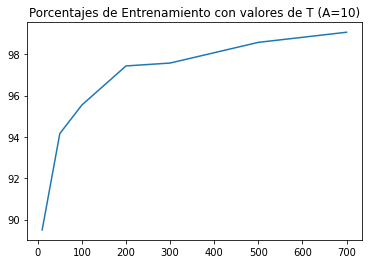

In [18]:
print('Resultados de entrenamiento (3000 img):')

#Para A = 10
T = [10, 50, 100, 200, 300, 500, 700]      # Numero de clasificadores 
resultados = [89.5, 94.16, 95.54, 97.43, 97.57, 98.57, 99.06] # Resultados obtenidos de clasificacion
Tiempos =[1,1,2,3,6,6,12]

print('Tiempos de ejecucion para cada iteracion(en minutos):',Tiempos)

plt.title("Porcentajes de Entrenamiento con valores de T (A=10)")
plt.plot(T, resultados)
plt.show()

Tiempos de ejecucion para cada iteracion(en minutos): [1, 6, 26, 40, 76, 81, 100]


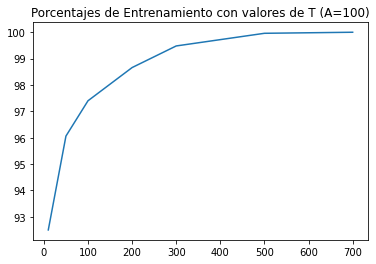

In [19]:
#Para A = 100
T = [10, 50, 100, 200, 300, 500, 700]      # Numero de clasificadores 
resultados = [92.5, 96.06, 97.4, 98.66, 99.48, 99.96, 100] # Resultados obtenidos de clasificacion
Tiempos =[1,6,26,40,76,81,100]

print('Tiempos de ejecucion para cada iteracion(en minutos):',Tiempos)

plt.title("Porcentajes de Entrenamiento con valores de T (A=100)")
plt.plot(T, resultados)
plt.show()

Tiempos de ejecucion para cada iteracion(en minutos): [4, 15, 25, 60, 90, 120, 180]


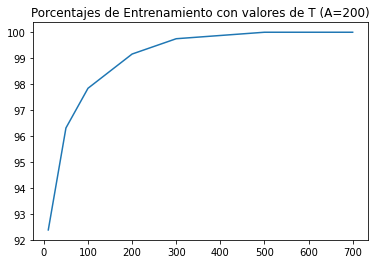

In [20]:
#Para A = 200
T = [10, 50, 100, 200, 300, 500, 700]      # Numero de clasificadores 
resultados = [92.38, 96.31, 97.84, 99.16, 99.75, 100, 100] # Resultados obtenidos de clasificacion
Tiempos =[4,15,25,60,90,120,180]

print('Tiempos de ejecucion para cada iteracion(en minutos):',Tiempos)

plt.title("Porcentajes de Entrenamiento con valores de T (A=200)")
plt.plot(T, resultados)
plt.show()

Tiempos de ejecucion para cada iteracion(en minutos): [6, 60, 85, 120, 200, 300, 480]


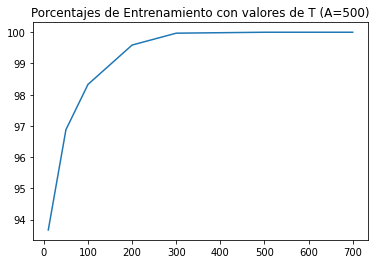

In [21]:
#Para A = 500
T = [10, 50, 100, 200, 300, 500, 700]      # Numero de clasificadores 
resultados = [93.67, 96.88, 98.33, 99.59, 99.97, 100, 100] # Resultados obtenidos de clasificacion
Tiempos =[6,60,85,120,200,300,480]

print('Tiempos de ejecucion para cada iteracion(en minutos):',Tiempos)

plt.title("Porcentajes de Entrenamiento con valores de T (A=500)")
plt.plot(T, resultados)
plt.show()

Tiempos de ejecucion para cada iteracion(en minutos): [36, 120, 167, 260, 812]


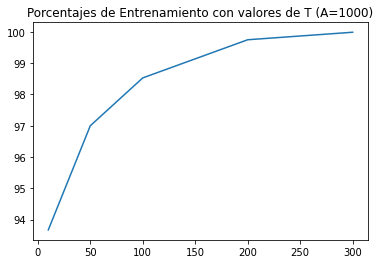

In [22]:
#Para A = 1000
T = [10, 50, 100, 200, 300]      # Numero de clasificadores 
resultados = [93.67, 97, 98.53, 99.75, 99.99] # Resultados obtenidos de clasificacion
Tiempos =[36,120,167,260,812]

print('Tiempos de ejecucion para cada iteracion(en minutos):',Tiempos)

plt.title("Porcentajes de Entrenamiento con valores de T (A=1000)")
plt.plot(T, resultados)
plt.show()

Como podemos ver en las graficas de entrenamiento, se logra llegar a porcentajes elevados (>98%) utilizando valores de T>=200, independientemente del valor de A, aunque con valores mayores de A se puede llegar a porcentajes elevados utilizando valores de T ligeramente menores, pero teniendo en cuenta el tiempo de ejecucion, a medida que se aumenta el valor de A, aumenta exponencialmente el tiempo de ejecucion, por lo que para el caso de entrenamiento, si queremos obtener los valores optimos de A y T para llegar a un 100% de aciertos, y con el tiempo minimo, utilizariamos A=100, T=700, con un tiempo de 100 minutos, pero tambien tenemos que tener en cuenta los resultados obtenidos al probar con 6000 imagenes distintas, lo cual veremos en las graficas que van a continuacion.

Por otro lado, no se ha notado ningun sobre entrenamiento, una vez que el porcentaje de aciertos llega a 100%, aumentando los parametros no causa ningun aumento en el porcentaje de fallos, como se puede ver en las graficas vistas anteriormente.

###**3.2.2 Resultados de prueba**

Resultados de prueba (6000 img):
Para A = 10:
Numero de clasificadores utilizados: [10, 50, 100, 200, 300, 500, 700]
Resultados obtenidos (Porcentaje de aciertos): [44.62, 46.7, 47.52, 48, 48.05, 48.4, 48.42]
Tiempos de ejecucion para cada iteracion(en minutos): [1, 1, 2, 3, 6, 6, 12]


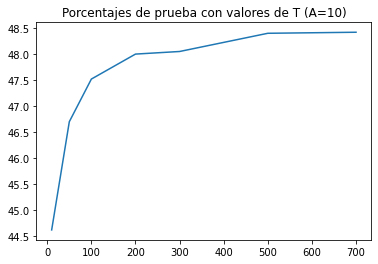

In [23]:
print('Resultados de prueba (6000 img):')
#Para A = 10
T = [10, 50, 100, 200, 300, 500, 700]      # Numero de clasificadores 
resultados = [44.62, 46.7, 47.52, 48, 48.05, 48.4, 48.42] # Resultados obtenidos de clasificacion
Tiempos =[1,1,2,3,6,6,12]
print('Para A = 10:')
print('Numero de clasificadores utilizados:',T)
print('Resultados obtenidos (Porcentaje de aciertos):',resultados)
print('Tiempos de ejecucion para cada iteracion(en minutos):',Tiempos)

plt.title("Porcentajes de prueba con valores de T (A=10)")
plt.plot(T, resultados)
plt.show()


Para A = 100:
Numero de clasificadores utilizados: [10, 50, 100, 200, 300, 500, 700]
Resultados obtenidos (Porcentaje de aciertos): [46.04, 47.57, 48.07, 48.25, 48.33, 48.58, 48.62]
Tiempos de ejecucion para cada iteracion(en minutos): [1, 6, 26, 40, 76, 81, 100]


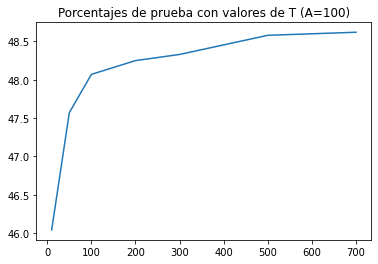

In [24]:
#Para A = 100
T = [10, 50, 100, 200, 300, 500, 700]      # Numero de clasificadores 
resultados = [46.04, 47.57, 48.07, 48.25, 48.33, 48.58, 48.62] # Resultados obtenidos de clasificacion
Tiempos =[1,6,26,40,76,81,100]
print('Para A = 100:')
print('Numero de clasificadores utilizados:',T)
print('Resultados obtenidos (Porcentaje de aciertos):',resultados)
print('Tiempos de ejecucion para cada iteracion(en minutos):',Tiempos)

plt.title("Porcentajes de prueba con valores de T (A=100)")
plt.plot(T, resultados)
plt.show()


Para A = 200:
Numero de clasificadores utilizados: [10, 50, 100, 200, 300, 500, 700]
Resultados obtenidos (Porcentaje de aciertos): [46.05, 47.69, 48.08, 48.31, 48.44, 48.53, 48.58]
Tiempos de ejecucion para cada iteracion(en minutos): [4, 15, 25, 60, 90, 120, 180]


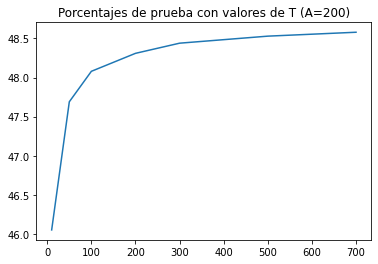

In [25]:
#Para A = 200
T = [10, 50, 100, 200, 300, 500, 700]      # Numero de clasificadores 
resultados = [46.05, 47.69, 48.08, 48.31, 48.44, 48.53, 48.58] # Resultados obtenidos de clasificacion
Tiempos =[4,15,25,60,90,120,180]
print('Para A = 200:')
print('Numero de clasificadores utilizados:',T)
print('Resultados obtenidos (Porcentaje de aciertos):',resultados)
print('Tiempos de ejecucion para cada iteracion(en minutos):',Tiempos)

plt.title("Porcentajes de prueba con valores de T (A=200)")
plt.plot(T, resultados)
plt.show()

Para A = 500:
Numero de clasificadores utilizados: [10, 50, 100, 200, 300, 500, 700]
Resultados obtenidos (Porcentaje de aciertos): [46.67, 47.85, 48.17, 48.34, 48.48, 48.56, 48.59]
Tiempos de ejecucion para cada iteracion(en minutos): [6, 60, 85, 120, 200, 300, 480]


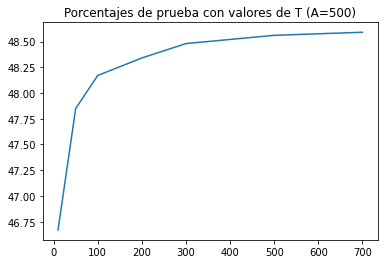

In [26]:
#Para A = 500
T = [10, 50, 100, 200, 300, 500, 700]      # Numero de clasificadores 
resultados = [46.67, 47.85, 48.17, 48.34, 48.48, 48.56, 48.59] # Resultados obtenidos de clasificacion
Tiempos =[6,60,85,120,200,300,480]
print('Para A = 500:')
print('Numero de clasificadores utilizados:',T)
print('Resultados obtenidos (Porcentaje de aciertos):',resultados)
print('Tiempos de ejecucion para cada iteracion(en minutos):',Tiempos)

plt.title("Porcentajes de prueba con valores de T (A=500)")
plt.plot(T, resultados)
plt.show()

Para A = 1000:
Numero de clasificadores utilizados: [10, 50, 100, 200, 300]
Resultados obtenidos (Porcentaje de aciertos): [46.44, 47.88, 48.21, 48.36, 48.59]
Tiempos de ejecucion para cada iteracion(en minutos): [36, 120, 167, 260, 812]


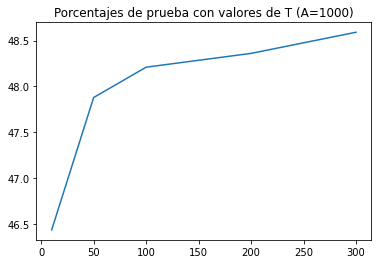

In [27]:
#Para A = 1000
T = [10, 50, 100, 200, 300]      # Numero de clasificadores 
resultados = [46.44, 47.88, 48.21, 48.36, 48.59] # Resultados obtenidos de clasificacion
Tiempos =[36,120,167,260,812]
print('Para A = 1000:')
print('Numero de clasificadores utilizados:',T)
print('Resultados obtenidos (Porcentaje de aciertos):',resultados)
print('Tiempos de ejecucion para cada iteracion(en minutos):',Tiempos)

plt.title("Porcentajes de prueba con valores de T (A=1000)")
plt.plot(T, resultados)
plt.show()

Lo primero que notaremos es que los porcentajes de acierto son muy bajos, esto se debe a que hemos utilizado solamente 3000 imagenes de entrenamiento, y 6000 de prueba, si hubiesemos utilizado más imagenes de entrenamiento los porcentajes serian mayores, ya que los clasificadores estarian mejor entrenados, pero como hemos visto en el apartado anterior, los tiempos aumentan exponencialmente, por lo que se ha decidido probar solamente con 3000 imagenes de entrenamiento.

Podemos ver en todas las graficas que los porcentajes de acierto aumentan considerablemente conforme aumenta la T, hasta llegar a T=200, donde el aumento ya no es tan visible (en algunos casos es tan bajo como 0.07%), pero el tiempo sigue aumentando exponencialmente, por lo que para que el algoritmo funcione correctamente necesitaremos una T con valor a partir de 200.


Luego para obtener el valor optimo de A, debemos mirar el mayor porcentaje de aciertos tanto de prueba como de entrenamiento, teniendo en cuenta el tiempo, por lo cual podemos deducir que el valor optimo general es A=100 y T=500, donde la tasa de aciertos de prueba es de 48.58%, y la de entrenamiento un 99.96%, con un tiempo de 81 minutos.